
<div class="alert alert-block alert-info">
   <h2 align="center"> <center><b> Reinforcement Learning Assignment 4 - Function Approximators Part 2: Deep Q Network </b></center></h2>

<br>
<center><font size="3">This notebook is a part of teaching material for ELEC-E8125</font></center>
<center><font size="3">Sep 4, 2023 - Nov 30, 2023</font></center>
<center><font size="3">Aalto University</font></center>
</div>


<a id='TOC'></a>

<div class="alert alert-block alert-success">
    
# Table of contents
* <a href='#1.'> 1. Introduction </a>
* <a href='#1.1'> 1.1 Task environments </a>
* <a href='#1.2'> 1.2 Learning Objectives </a>
* <a href='#1.3'> 1.3 Code Structure & Files </a>
* <a href='#1.4'> 1.4 Execution time </a>
* <a href='#2.'> 2. A (not-so-)deep Q-network</a>
* <a href='#3.'> 3. Submitting </a>
* <a href='#3.1'> 3.1 Feedback </a>

<a href='#T1'><b>Student Task 1.</b> Implementing DQN (10 points) </a>\
<a href='#Q1'><b>Student Question 1.1</b> Considering Continuous Action Spaces (5 points) </a>\
<a href='#Q2'><b>Student Question 1.2</b> Continuous Action Spaces Part 1 (15 points) </a>\
<a href='#Q3'><b>Student Question 1.3</b> The Target Network (10 points) </a>
 

**Total Points:** 40

# 1. Introduction <a id='1.'></a>

In various real-world scenarios, dealing with high-dimensional state spaces makes it impractical to compute and store Q-values for every possible state-action pair in a Q-table. To address this challenge, we turn to function approximators. In this assignment, you will progress creating a basic Deep Q-Network (DQN) in the **Cartpole** and **LunarLander** environment.

**Please start working on this assignment early since the DQN will take some time to train.**


<div style="display:flex">
     <div style="flex:1;padding-left:100px;">
          <img src="imgs/cartpole.png" width="300"/>
         <figcaption style="flex:1;padding-left:20px;">  Figure 1: The Cartpole environment. </figcaption>
     </div>
     <div style="flex:1;padding-left:70px;">
          <img src="imgs/lunar_lander.png" width="300"/>
         <figcaption style="flex:1;padding-left:20px;">  Figure 2: The Lunarlander environment. </figcaption>
     </div>

</div>

Useful Sources:

- Mnih, Volodymyr, et al. "Playing atari with deep reinforcement learning." arXiv preprint arXiv:1312.5602 (2013). https://arxiv.org/pdf/1312.5602.pdf


## 1.1 Task environments: <a id='1.1'></a>
In this excercise, we will mainly use DQN for two tasks:
- Cartpole(https://gymnasium.farama.org/environments/classic_control/cart_pole/): This environment corresponds to the version of the cart-pole problem described by Barto, Sutton, and Anderson in “Neuronlike Adaptive Elements That Can Solve Difficult Learning Control Problem”. A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum is placed upright on the cart and the goal is to balance the pole by applying forces in the left and right direction on the cart.

- Lunar Lander (https://gymnasium.farama.org/environments/box2d/lunar_lander/): This environment is a classic rocket trajectory optimization problem. According to Pontryagin’s maximum principle, it is optimal to fire the engine at full throttle or turn it off. This is the reason why this environment has discrete actions: engine on or off.

## 1.2 Learning Objectives: <a id='1.1'></a>
- Understand why and how function approximators can be used for Q-learning
- Understand the Deep Q-Network RL algorithm

## 1.3 Code Structure & Files <a id='1.2'></a>

```ex4_dqn.ipynb``` is the file needed to be modified for this part of the assignment.  

<span style="color:red"> **# IMPORTANT: DO NOT FORGET ANOTHER TASK IN ```ex4_rbf.ipynb```** </span>

```
├───cfg                            # Config files for environments
├───imgs                           # Images used in notebook
├───results
│   └───CartPole-v1
│   │   ├───logging                
│   │   │    └───logging.pkl        # Contains logged data
│   │   ├───model              
│   │   │    └───*dqn.pt            # Contains trained model
│   │   └───video                   # Videos saved
│   │   └───*cartpole_dqn.png       # Contains training performance plot
│   └───LunarLander-v2
│   │   ├───logging                
│   │   │    └───logging.pkl        # Contains logged data
│   │   ├───model              
│   │   │    └───*dqn.pt            # Contains trained model
│   │   └───video                   # Videos saved
│   │   └───*lunarlander_dqn.png    # Contains training performance plot
│   ex4_dqn.ipynb                   # 2nd assignment file containing tasks <---------This task
│   ex4_rbf.ipynb                   # 1st assignment file containing tasks <---------
│   train.py                        # Contains train and test functions 
│   utils.py                        # Contains useful functions 
└───buffer.py                       # Contains buffer functions
```

## 1.4 Execution time <a id='1.4'></a>

The training of these methods might take more than 40 mins depends on the server. If you have problem of experiment running takes too much time, you can download the jupyter notebook and test it locally.

# 2. A (not-so-)deep Q-network <a id='2.'></a>

<a id='T1'></a>
<div class=" alert alert-warning">
    <h3><b>Student Task 1.</b> Implementing DQN (10 points) </h3> 

Finish the incomplete code in DQNAgent (functions ```update``` and ```get_action```, marked with ```TODO```) to implement a DQN agent.

**See Figure 3 for an example training performance plot for cartpole. Save the training performance plots, and check if they are in the right place (the paths please refer to <a href='#3.'>Submitting<a>).**

<figure style="text-align: center">
<img src="imgs/dqn.png" width="300px">
<figcaption style="text-align: center"> Figure 3: The training performance plot for cartpole-dqn might look something like this. </figcaption>
</figure>
    
🔝	<a href='#TOC'><b>Table of Contents</b></a>
</div>


In [16]:
import sys, os
sys.path.insert(0, os.path.abspath(".."))
from typing import List
import numpy as np
import torch, random, copy, yaml, time
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from pathlib import Path

import utils as u
import train as t

from IPython.display import Video # to display videos

device = 'cpu'

In [17]:
def mlp(in_dim, mlp_dims: List[int], out_dim, act_fn=nn.ReLU, out_act=nn.Identity):
    """Returns an MLP."""
    if isinstance(mlp_dims, int): raise ValueError("mlp dimensions should be list, but got int.")

    layers = [nn.Linear(in_dim, mlp_dims[0]), act_fn()]
    for i in range(len(mlp_dims)-1):
        layers += [nn.Linear(mlp_dims[i], mlp_dims[i+1]), act_fn()]
    # the output layer
    layers += [nn.Linear(mlp_dims[-1], out_dim), out_act()]
    return nn.Sequential(*layers)

In [18]:
class DQNAgent(object):
    def __init__(self, state_shape, n_actions,
                 batch_size=32, hidden_dims=[12], gamma=0.98, lr=1e-3, grad_clip_norm=1000, tau=0.001):
        self.n_actions = n_actions
        self.state_dim = state_shape[0]
        self.policy_net = mlp(self.state_dim, hidden_dims, n_actions).to(device)
        self.target_net = copy.deepcopy(self.policy_net)
        self.target_net.eval()
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=float(lr))

        self.batch_size = batch_size
        self.gamma = gamma
        self.grad_clip_norm = grad_clip_norm
        self.tau = tau
        
        self.counter = 0

    def update(self, buffer):
        """ One gradient step, update the policy net."""
        start = time.perf_counter()
        self.counter += 1
        # Do one step gradient update
        batch = buffer.sample(self.batch_size, device=device)
        # Hint:
        #    state = batch.state
        #    action = batch.action 
        #    next_state = batch.next_state
        #    reward = batch.reward 
        #    not_done = batch.not_done 
        
        # TODO: Task 3: Finish the DQN implementation.
        # Hints: 1. You can use torch.gather() to gather values along an axis specified by dim. 
        #        2. torch.max returns a namedtuple (values, indices) where values is the maximum 
        #           value of each row of the input tensor in the given dimension dim.
        #           And indices is the index location of each maximum value found (argmax).
        #        3.  batch is a namedtuple, which has state, action, next_state, not_done, reward
        #           you can access the value be batch.<name>, e.g, batch.state
        #        4. check torch.nn.utils.clip_grad_norm_() to know how to clip grad norm
        #        5. You can go throught the PyTorch Tutorial given on MyCourses if you are not familiar with it. 
        # calculate the q(s,a)
        ########## You code starts here #########
        qs = torch.gather(input = self.policy_net(batch.state), dim=1, index=batch.action.type(torch.int64))

        q_actions_target = self.target_net(batch.next_state)

        m = torch.max(input=q_actions_target, dim=1).values
        
        q_tar = batch.reward + self.gamma * torch.reshape(m, batch.not_done.size()) * batch.not_done

        l = (qs - q_tar.detach())**2 * 0.5
        loss = l.sum()

        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), self.grad_clip_norm)
        self.optimizer.step()

        ########## You code ends here #########

        # update the target network
        u.soft_update_params(self.policy_net, self.target_net, self.tau)
        
        end = time.perf_counter()
        update_time = end - start
        return {'loss': loss.item(), 
                'q_mean': qs.mean().item(),
                'num_update': self.counter,
                'update_time': update_time}


    @torch.no_grad()
    def get_action(self, state, epsilon=0.05):
        # TODO:  Task 3: implement epsilon-greedy action selection
        ########## You code starts here #########
        if np.random.random() <= epsilon:
            action = np.random.randint(0, self.n_actions)
        else:
            q_actions = self.policy_net(torch.from_numpy(state).to(device))
            action = torch.argmax(q_actions).item()
        ########## You code ends here #########
        return action


    def save(self, fp):
        path = fp/'dqn.pt'
        torch.save({
            'policy': self.policy_net.state_dict(),
            'policy_target': self.target_net.state_dict()
        }, path)

    def load(self, fp):
        path = fp/'dqn.pt'
        d = torch.load(path)
        self.policy_net.load_state_dict(d['policy'])
        self.target_net.load_state_dict(d['policy_target'])

In [19]:
# init agent
with open(Path().cwd()/'cfg'/'cartpole_dqn.yaml', 'r') as f:
    cfg = t.Struct(**yaml.safe_load(f))
    
agent = DQNAgent(state_shape=cfg.state_shape, n_actions=cfg.n_actions, batch_size=cfg.batch_size, hidden_dims=cfg.hidden_dims,
                 gamma=cfg.gamma, lr=cfg.lr, tau=cfg.tau)

In [20]:
# Trainig takes approximately 40 mins,depends on server
t.train(agent,  cfg_path=Path().cwd()/'cfg'/'cartpole_dqn.yaml',) 

Numpy/Torch/Random Seed:  436
{'ep_reward': 87.0, 'episode': 0, 'epsilon': 1.0, 'ep_avr': 0.015567317605018616, 'ts_avr': 0.00017427558871521348}
{'ep_reward': 13.0, 'episode': 100, 'epsilon': 0.6666666666666666, 'ep_avr': 0.048203808926045894, 'ts_avr': 0.0023084805362659105, 'loss': 43.918678283691406, 'q_mean': 0.9568110108375549, 'num_update': 1810, 'update_time': 0.002208501100540161}
{'ep_reward': 14.0, 'episode': 200, 'epsilon': 0.5, 'ep_avr': 0.04202133256942034, 'ts_avr': 0.0026655748813132624, 'loss': 26.035228729248047, 'q_mean': 2.1142663955688477, 'num_update': 3384, 'update_time': 0.002270694822072983}
{'ep_reward': 10.0, 'episode': 300, 'epsilon': 0.4, 'ep_avr': 0.0360624061152339, 'ts_avr': 0.0026865852496294833, 'loss': 54.84806442260742, 'q_mean': 3.1163113117218018, 'num_update': 4724, 'update_time': 0.0022336766123771667}
{'ep_reward': 14.0, 'episode': 400, 'epsilon': 0.3333333333333333, 'ep_avr': 0.030361013561487196, 'ts_avr': 0.0026721496108715707, 'loss': 57.852

Numpy/Torch/Random Seed:  436


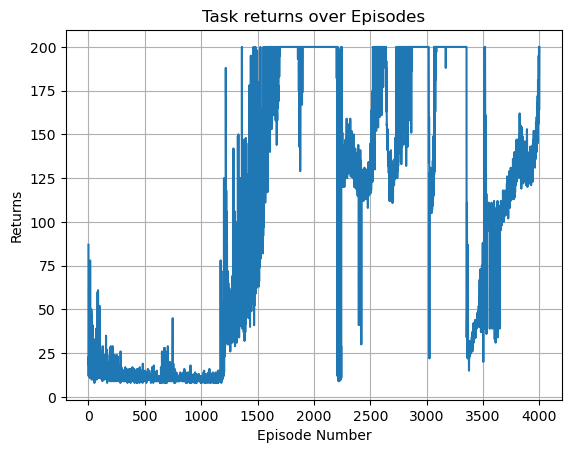

In [21]:
# Visualize the DQN training plots for the cartpole task
t.plot(save_name='cartpole_dqn.png', cfg_path=Path().cwd()/'cfg'/'cartpole_dqn.yaml',)

In [22]:
t.test(agent, cfg_path=Path().cwd()/'cfg'/'cartpole_dqn.yaml', cfg_args=dict(save_video=True))

Numpy/Torch/Random Seed:  436
{'episode': 0, 'ep_reward': 176.0}
{'episode': 1, 'ep_reward': 190.0}
{'episode': 2, 'ep_reward': 183.0}
{'episode': 3, 'ep_reward': 189.0}
{'episode': 4, 'ep_reward': 200.0}
{'episode': 5, 'ep_reward': 197.0}
{'episode': 6, 'ep_reward': 192.0}
{'episode': 7, 'ep_reward': 200.0}
{'episode': 8, 'ep_reward': 181.0}
{'episode': 9, 'ep_reward': 200.0}


In [23]:
Video(Path().cwd()/'results'/'CartPole-v1'/'video'/'test'/'ex4_dqn-episode-0.mp4',
      embed=True, html_attributes="loop autoplay") # Set html_attributes="controls" for video control

In [24]:
# init agent
with open(Path().cwd()/'cfg'/'lunarlander_dqn.yaml', 'r') as f:
    cfg = t.Struct(**yaml.safe_load(f))
    
agent = DQNAgent(state_shape=cfg.state_shape, n_actions=cfg.n_actions, batch_size=cfg.batch_size, hidden_dims=cfg.hidden_dims,
                 gamma=cfg.gamma, lr=cfg.lr, tau=cfg.tau)

In [25]:
# Trainig takes approximately 60 mins,depends on server
t.train(agent, cfg_path=Path().cwd()/'cfg'/'lunarlander_dqn.yaml', cfg_args=dict()) 

Numpy/Torch/Random Seed:  436
{'ep_reward': -98.95490307738619, 'episode': 0, 'epsilon': 1.0, 'ep_avr': 0.03579378500580788, 'ts_avr': 0.0003187348630940803}
{'ep_reward': 1.9456400534397318, 'episode': 100, 'epsilon': 0.6666666666666666, 'ep_avr': 0.4335331168025732, 'ts_avr': 0.0036852105036244646, 'loss': 7512.2705078125, 'q_mean': -8.089284896850586, 'num_update': 10870, 'update_time': 0.0034259893000125885}
{'ep_reward': -135.78191562316368, 'episode': 200, 'epsilon': 0.5, 'ep_avr': 0.6883160620927811, 'ts_avr': 0.00401575239955202, 'loss': 1830.8837890625, 'q_mean': 0.04877173900604248, 'num_update': 27988, 'update_time': 0.0035423263907432556}
{'ep_reward': -83.06382192801723, 'episode': 300, 'epsilon': 0.4, 'ep_avr': 1.37446513120085, 'ts_avr': 0.004099003039439424, 'loss': 2878.318115234375, 'q_mean': 9.576367378234863, 'num_update': 61493, 'update_time': 0.003459896892309189}
{'ep_reward': 76.23044742060051, 'episode': 400, 'epsilon': 0.3333333333333333, 'ep_avr': 1.718337898

Numpy/Torch/Random Seed:  436


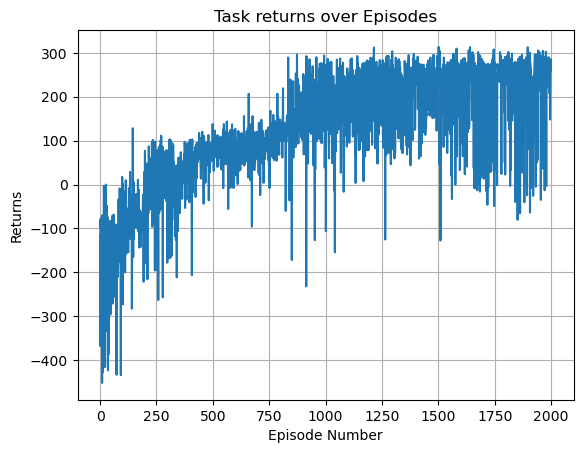

In [26]:
# Visualize the DQN training plots for the lunarlander task
t.plot(save_name='lunarlander_dqn.png', cfg_path=Path().cwd()/'cfg'/'lunarlander_dqn.yaml', cfg_args=dict())

In [27]:
t.test(agent, cfg_path=Path().cwd()/'cfg'/'lunarlander_dqn.yaml', cfg_args=dict(save_video=True))

Numpy/Torch/Random Seed:  436
{'episode': 0, 'ep_reward': 254.53979957868137}
{'episode': 1, 'ep_reward': 267.00902258280195}
{'episode': 2, 'ep_reward': 274.6111153102406}
{'episode': 3, 'ep_reward': 233.52758284658574}
{'episode': 4, 'ep_reward': 256.16724519406705}
{'episode': 5, 'ep_reward': 248.0196162741574}
{'episode': 6, 'ep_reward': 270.7070575192043}
{'episode': 7, 'ep_reward': 51.10998739244809}
{'episode': 8, 'ep_reward': 228.48671640527894}
{'episode': 9, 'ep_reward': 246.92616839241268}


In [28]:
Video(Path().cwd()/'results'/'LunarLander-v2'/'video'/'test'/'ex4_dqn-episode-8.mp4',
      embed=True, html_attributes="loop autoplay") # Set html_attributes="controls" for video control

<a id='Q1'></a>
<div class=" alert alert-warning">
    <h3><b>Student Question 1.1</b> Considering Continuous Action Spaces (5 points) </h3> 

Can Q-learning be used directly in environments with continuous action spaces?
    
🔝	<a href='#TOC'><b>Table of Contents</b></a>
</div>


Directly applying Q-learning to a continuous action space can be challenging. One effective strategy to make Q-learning applicable is to employ discretization. When dealing with high-dimensional action spaces, it's beneficial to leverage independence assumptions, as they can help reduce the overall number of discrete actions, making the problem more manageable and efficient for Q-learning. For Q-learning to effectively compute the Q-function for specific state-action pairs, it necessitates discrete and finite sets of actions and states as a fundamental requirement.

<a id='Q2'></a>
<div class=" alert alert-warning">
    <h3><b>Student Question 1.2</b> Continuous Action Spaces Part 1 (15 points) </h3> 

1.Which steps of the algorithm would be difficult to compute in case of a continuous action space?
    
2.If any, what could be done to solve them?
    
    
🔝	<a href='#TOC'><b>Table of Contents</b></a>
</div>


Two crucial challenges must be addressed when applying Q-learning. Firstly, continuous action spaces present a significant hurdle when computing the maximum Q-value for the next state, as assessing the value across an infinite set of potential actions is impractical. A potential but imperfect solution is to discretize the action space. Secondly, there's the issue of storing Q-values, actions, and states. In continuous action spaces with a potentially infinite number of actions, managing and selecting actions efficiently becomes a formidable problem. These challenges underscore the importance of thoughtful strategies for handling continuous action spaces in Q-learning.

<a id='Q3'></a>
<div class=" alert alert-warning">
    <h3><b>Student Question 1.3</b> The Target Network (10 points) </h3> 

In DQN, we use an additional target network to calculate the target Q value.
    
1.Why we need an additional target network ? 
    
2.Can we just use the same network (no an additional target network ) in calculating both Q(s,a) and maxa(Q(s′,·))? why or why not?
    
3.What will happen if we do not stop gradient of the target Q value?
    
🔝	<a href='#TOC'><b>Table of Contents</b></a>
</div>


1. The introduction of an additional target network serves a dual purpose, significantly enhancing the stability and effectiveness of the training process in Q-learning. When we employ the same network for both estimating Q-values (known as the policy network) and performing Q-learning updates, it can introduce training instability. In contrast, the target network provides a steady and delayed stream of Q-value estimations. Periodically, it synchronizes its weights with those of the policy network, but these updates occur less frequently. This temporal smoothing mechanism plays a critical role in preventing divergence issues during training. The use of this supplementary neural network is crucial to counteract potential bias stemming from bootstrapping, ensuring that estimated Q-values remain on a stable course.

2. While it is theoretically possible to use the same network for both Q(s,a) and maxa(Q(s′,·)), this approach often leads to training instability and divergence, as previously mentioned. The primary reason behind this is that, during the Q-learning update, it attempts to simultaneously adapt the Q-value estimate (Q(s,a)) and the target value (maxa(Q(s′,·))).

3. Failing to halt the gradient flow for the target Q-value can result in a problematic situation. In essence, this can lead to a high degree of correlation between the Q-value estimates and their corresponding targets, ultimately causing training to become unstable and sluggish.

# 3. Submitting <a id='3.'></a>
Ensure all tasks and questions (in ```ex4_dpn.ipynb``` and ```ex4_rbf.ipynb```) are answered and and that the necessary plots are saved in the appropriate locations. The relevant plots and files needed to be submitted for this assignment are:


- Training performance plots:
  - `cartpole_dqn.png`: Cartpole, training performance plots in terms of episode and episodic reward
  - `lunarlander_dqn.png`: Lunarlander, training performance plots in terms of episode and episodic reward 
<br>
<br>

  

- Model files:
  - `dqn.pt`: Trained model


Ensure the model files and plots are saved in correct paths:
- ```results/CartPole-v1/cartpole_dqn``` Training result for Cartpole environment
- ```results/CartPole-v1/model/dqn.pt``` Model for Cartpole environment
- ```results/LunarLander-v2/lunarlander_dqn.png``` Training result for LunarLander environment
- ```results/LunarLander-v2/model/dqn.pt``` Model for LunarLander environment


<span style="color:red"> **# IMPORTANT: DO NOT FORGET ANOTHER TASK IN ```ex4_rbf.ipynb```** </span>

## 3.1 Feedback <a id='3.1'></a>

In order to help the staff of the course as well as the forthcoming students, it would be great if you could answer to the following questions in your submission:

1) How much time did you spend solving this exercise? (change the ```hrs``` variable below to a floating point number representing the number of hours taken e.g. 5.43)

In [ ]:
hrs = None

2) Difficulty of each task/question from 1-5 (int or float)

In [ ]:
T1 = None   # Implementing DQN (10 points)
Q1_1 = None # Question 1.1 Considering Continuous Action Spaces (5 points)
Q1_2 = None # Question 1.2 Continuous Action Spaces Part 1 (15 points)
Q1_3 = None # Question 1.3 The Target Network (10 points)

3) How well did you understand the content of the task/question from 1-5? (int or float)

In [ ]:
T1 = None   # Implementing DQN (10 points)
Q1_1 = None # Question 1.1 Considering Continuous Action Spaces (5 points)
Q1_2 = None # Question 1.2 Continuous Action Spaces Part 1 (15 points)
Q1_3 = None # Question 1.3 The Target Network (10 points)

4) General feedback. Consider questions like:

    - Did the content of the lecture relate well with the assignment?
    - To what extent did you find the material to be potentially useful for your research and studies?
    
Please share any additional feedback, suggestions, or comments you have about the lecture, assignment, or course content. Your input is valuable in helping us improve the learning experience.

DOUBLE CLICK HERE TO EDIT, CLEAR THIS TEXT AND ANSWER HERE